In [7]:
# LLM Initialization
import os
#from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage,SystemMessage,AIMessage

#load_dotenv()
if os.environ.get("GROQ_API_KEY"):
    print("API key exists")
else:
    raise ValueError("Groq API Key not found")


groq_api_key =os.environ.get("GROQ_API_KEY")
llm = ChatGroq(api_key=groq_api_key, model="llama-3.1-8b-instant",temperature=0.7,max_tokens=None)

# Put all the imports at the top to make sure we have all modules in our notebook
from langchain_core.messages import HumanMessage,SystemMessage,AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableSequence, RunnableLambda, RunnableBranch
from pydantic import BaseModel, Field
from typing import Literal


API key exists


### **Conditional Chains:**
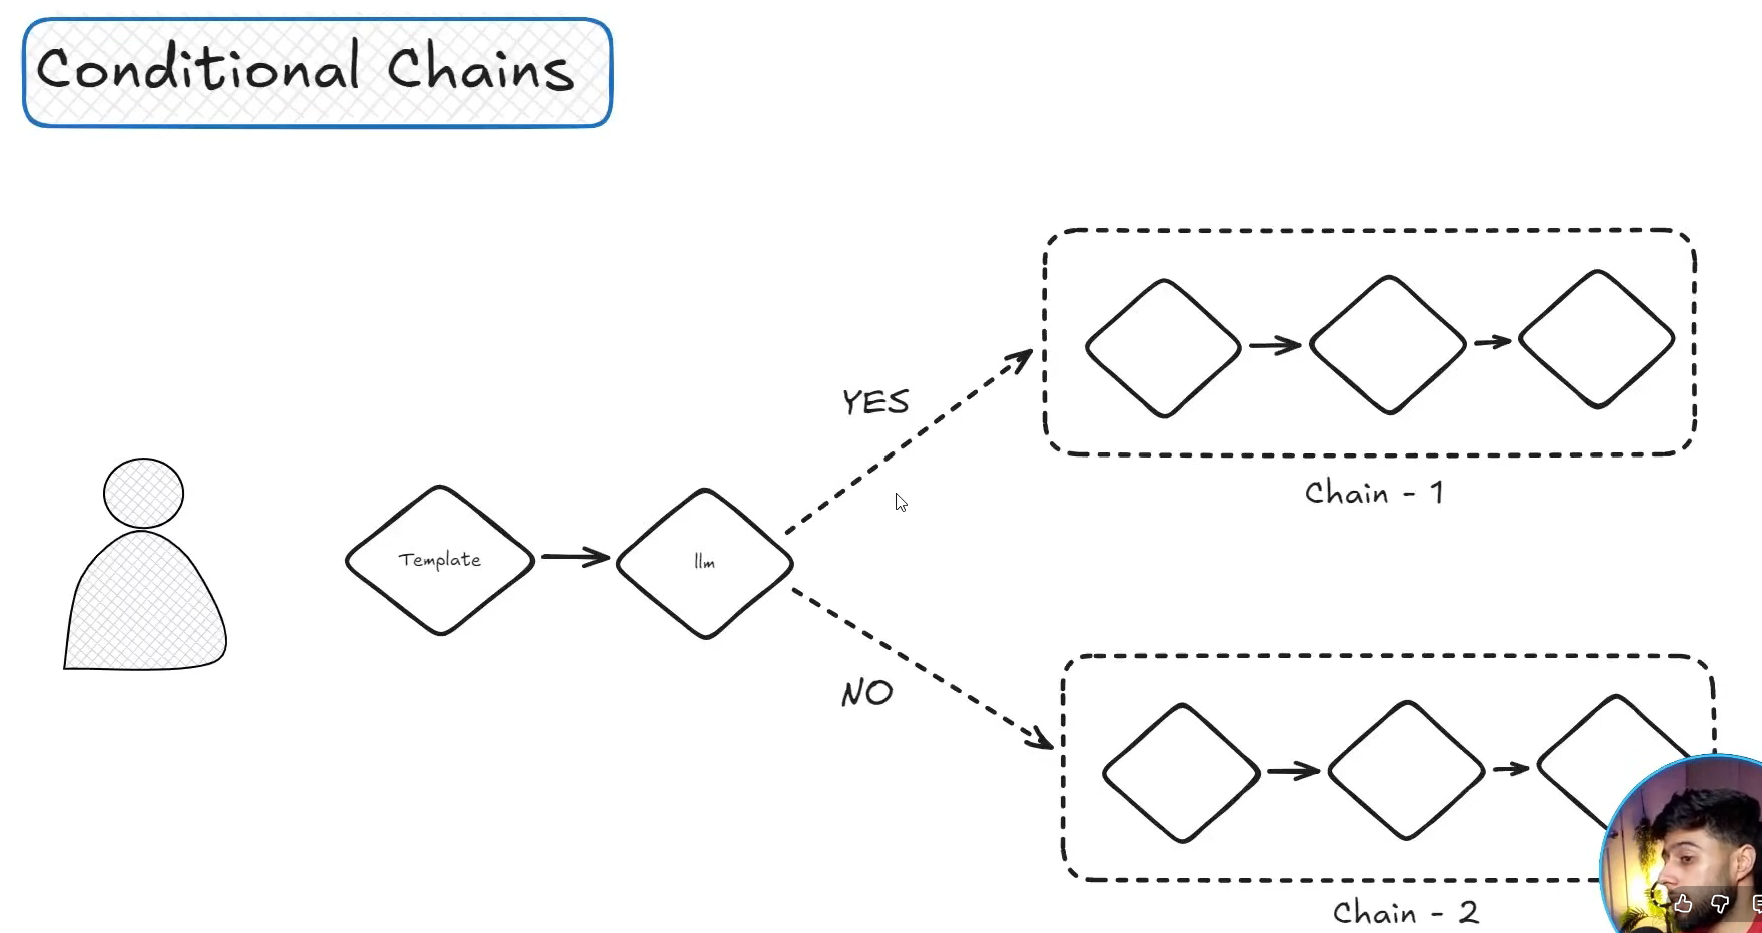

In [5]:
class llm_schema(BaseModel):
    category: Literal["positive", "negative", "neutral"] = Field(
        ..., description="The sentiment category of the movie review."
    )


llm_structured_output=llm.with_structured_output(llm_schema)
result=llm_structured_output.invoke([HumanMessage(content="The movie was fantastic! I loved every moment of it.")])
print(result)


category='positive'


## **Chain with Conditional Chains:**

In [13]:
# TASK -1  [Prompt]

prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are a movie review evaluator."),
    ("human", "Please categorize the movie review as positive, negative, or neutral: {review}")
])

#TASK-2 [LLM with Groq]
llm_groq = ChatGroq(api_key=groq_api_key, model="llama-3.1-8b-instant",temperature=0.7,max_tokens=None)
llm_groq_structured = llm_groq.with_structured_output(llm_schema)

# TASK-3 [Output Parser]
def pydantic_json(input: llm_schema) -> str:
    return input.model_dump()['category']
pydantic_json_lamda=RunnableLambda(pydantic_json)

**Condition Chain 1:**

In [14]:
# Task-1 [Prompt]
linkedin_prompt=ChatPromptTemplate.from_messages([
("system","You are a LinkedIn post assistant"),
("human","Create a post for the following text for Linkedin:{text}")
])

# Task-2 [LLM]
llm_groq=ChatGroq(api_key=groq_api_key, model="llama-3.1-8b-instant",temperature=0.7,max_tokens=None)

# Task-3 [String Parser]
str_parser=StrOutputParser()

chain_linkedin=linkedin_prompt | llm_groq | str_parser


# TASK-4 [Custom Runnable to convert to dictionary]
def dictionary_maker(text: str) -> dict:
    return {"text": text}
dictionary_maker_ruunable = RunnableLambda(dictionary_maker)



**Conditional Chain 2:**


In [15]:
def insta_chain(text: dict):
    text=text['text']
    
    # TASK-1 [Prompt]
    insta_prompt=ChatPromptTemplate.from_messages([
    ("system","You are an Instagram post assistant"),   
    ("human","Create a post for the following text for Instagram:{text}")
    ])  

    # TASK-2 [LLM]
    llm_groq=ChatGroq(api_key=groq_api_key, model="llama-3.1-8b-instant",temperature=0.7,max_tokens=None)

    # TASK-3 [String Parser]
    str_parser=StrOutputParser()

    chain_insta=insta_prompt | llm_groq | str_parser

    result_insta=chain_insta.invoke({"text":text})
    return result_insta
insta_chain_ruunable=RunnableLambda(insta_chain)

**Final Orchestration:**

In [16]:
conditional_chain=RunnableBranch(
    (lambda x:"positive" in x, chain_linkedin),
    insta_chain_ruunable
)

final_orchestrator = prompt_template | llm_groq_structured | pydantic_json_lamda | conditional_chain
final_orchestrator.invoke({"review": "KGF"})

"Here's a potential LinkedIn post:\n\n**New Day, New Opportunities**\n\nI'm starting the day with a positive attitude and a heart full of gratitude. No matter what challenges we face, it's essential to approach them with a can-do spirit and a mindset that's open to growth.\n\nWho else is feeling positive today? What's on your agenda for the day? Share your goals and aspirations, and let's support each other in achieving great things.\n\n**Let's make today count!**\n\n(Add a relevant image or GIF to make the post more engaging)\n\nYou can customize it according to your preferences and style."